In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing

%matplotlib inline

# Visualization
import seaborn as sns
from matplotlib import pyplot as plt

import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from matplotlib_venn import venn3

from wordcloud import WordCloud

from collections import Counter
import re
import string
from nltk.corpus import stopwords
stop = stopwords.words('english')


sns.set(style="white", context="talk")

/home/mukul/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/mukul/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/mukul/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/mukul/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/mukul/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
df_train = pd.read_csv('/home/mukul/Documents/all/train.csv')



COLUMNS = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']



# Adding 'none' columns if there is no '1' in COLUMNS
df_train['none'] = (df_train[COLUMNS].max(axis=1) == 0).astype(int)
COLUMNS.append('none')
CATEGORIES = COLUMNS.copy()

print(df_train.shape)
print(df_train.columns.values)

(159571, 9)
['id' 'comment_text' 'toxic' 'severe_toxic' 'obscene' 'threat' 'insult'
 'identity_hate' 'none']


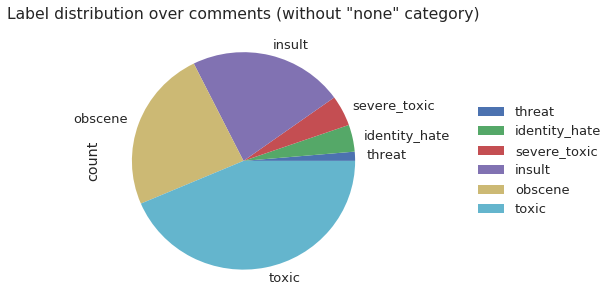

In [3]:
df_distribution = df_train[COLUMNS].sum()\
                            .to_frame()\
                            .rename(columns={0: 'count'})\
                            .sort_values('count')

df_distribution.drop('none').plot.pie(y='count',
                                      title='Label distribution over comments (without "none" category)',
                                      figsize=(5, 5))\
                            .legend(loc='center left', bbox_to_anchor=(1.3, 0.5))

In [4]:
df_distribution.sort_values('count', ascending=False)

,count
none,143346
toxic,15294
obscene,8449
insult,7877
severe_toxic,1595
identity_hate,1405
threat,478



The three major labels are :

    toxic
    obscene
    insult

Let's take a look at the number of comment for each label combination.

Here we are looking for combinations that are frequent. Which would indicate a correlation between categories

In [5]:

df_comb = df_train.groupby(COLUMNS)\
                    .size()\
                    .sort_values(ascending=False)\
                    .reset_index()\
                    .rename(columns={0: 'count'})
df_comb.head(n=10)

,toxic,severe_toxic,obscene,threat,insult,identity_hate,none,count
0,0,0,0,0,0,0,1,143346
1,1,0,0,0,0,0,0,5666
2,1,0,1,0,1,0,0,3800
3,1,0,1,0,0,0,0,1758
4,1,0,0,0,1,0,0,1215
5,1,1,1,0,1,0,0,989
6,1,0,1,0,1,1,0,618
7,0,0,1,0,0,0,0,317
8,0,0,0,0,1,0,0,301
9,1,1,1,0,1,1,0,265




We can see several things :

    As expected, the 'none' label is clearly ahead with 86061 comments
    'toxic', which is the first 'real' label, is coming in all combination from rank 1 to 6
    In this 6 rows, 'obscene' comes 4 times
    The number of comments for each combination drops exponentially

Let's check the correlation matrix :



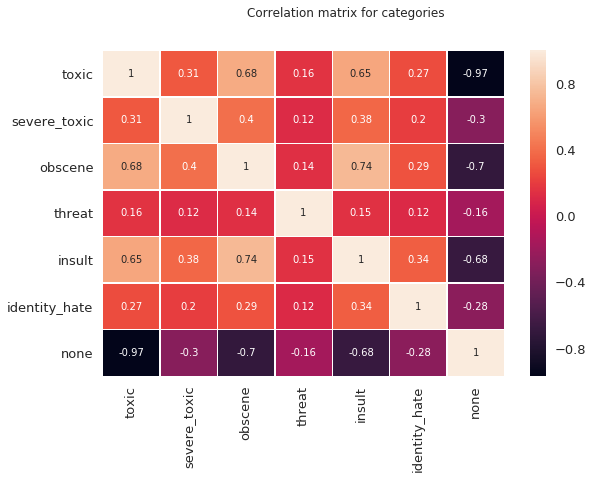

In [6]:
f, ax = plt.subplots(figsize=(9, 6))
f.suptitle('Correlation matrix for categories')
sns.heatmap(df_train[COLUMNS].corr(), annot=True, linewidths=.5, ax=ax)



The correlation matrix shows interesting things :

    'toxic' is clearly correlated with 'obscene' and 'insult' (0.68 and 0.65)
    'toxic' and 'severe_toxic' are only got a 0.31 correlation factor
    'insult' and 'obscene' have a correlation factor of 0.74

From my point of view, there are several combinations that are worth digging into :

    'toxic' <-> 'severe_toxic'. The semantic of these two categories seems to show some kind of graduation between them
    'toxic' <-> 'insult' and 'toxic' <-> 'obscene'
    'insult' <-> 'obscene'



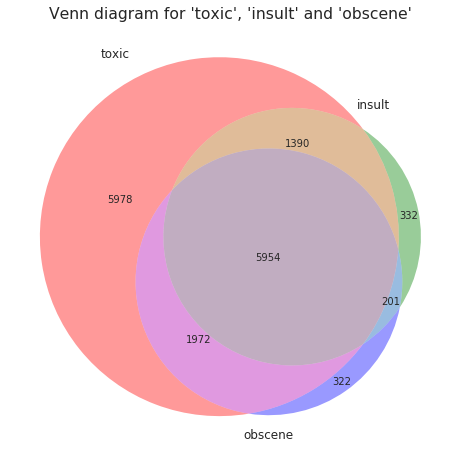

In [7]:
t = df_train[(df_train['toxic'] == 1) & (df_train['insult'] == 0) & (df_train['obscene'] == 0)].shape[0]
i = df_train[(df_train['toxic'] == 0) & (df_train['insult'] == 1) & (df_train['obscene'] == 0)].shape[0]
o = df_train[(df_train['toxic'] == 0) & (df_train['insult'] == 0) & (df_train['obscene'] == 1)].shape[0]

t_i = df_train[(df_train['toxic'] == 1) & (df_train['insult'] == 1) & (df_train['obscene'] == 0)].shape[0]
t_o = df_train[(df_train['toxic'] == 1) & (df_train['insult'] == 0) & (df_train['obscene'] == 1)].shape[0]
i_o = df_train[(df_train['toxic'] == 0) & (df_train['insult'] == 1) & (df_train['obscene'] == 1)].shape[0]

t_i_o = df_train[(df_train['toxic'] == 1) & (df_train['insult'] == 1) & (df_train['obscene'] == 1)].shape[0]


# Make the diagram
plt.figure(figsize=(8, 8))
plt.title("Venn diagram for 'toxic', 'insult' and 'obscene'")
venn3(subsets = (t, i, t_i, o, t_o, i_o, t_i_o), 
      set_labels=('toxic', 'insult', 'obscene'))
plt.show()



This venn diagram demonstrates the correlations found in the previous visualization.

    There is only a small part of 'insult' and 'obscene' that are not also labelled 'toxic'.
    3610 comments are labelled with all 3 categories.

Note: The library used for the Venn diagram does not have a venn4 object, that's why I couldn't display 'severe_toxic' with them.

Let's take a look at the Venn diagram between 'toxic' and 'severe_toxic'.


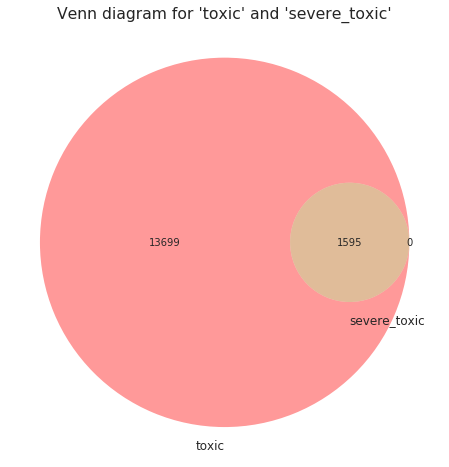

In [8]:
t = df_train[(df_train['toxic'] == 1) & (df_train['severe_toxic'] == 0)].shape[0]
s = df_train[(df_train['toxic'] == 0) & (df_train['severe_toxic'] == 1)].shape[0]

t_s = df_train[(df_train['toxic'] == 1) & (df_train['severe_toxic'] == 1)].shape[0]


# Make the diagram
plt.figure(figsize=(8, 8))
plt.title("Venn diagram for 'toxic' and 'severe_toxic'")
venn2(subsets = (t, s, t_s), 
      set_labels=('toxic', 'severe_toxic'))
plt.show()


    The 'severe_toxic' category is completely contained in 'toxic' which goes in favor of the semantic link between the two category names.
    The 0.31 correlation factor is explained by the fact that 'severe_toxic' representes a small percentage (11.67%) of 'toxic'.

Before diving into words, let's analyze the comment structure :

    Total length
        It could indicate the writer implication (either in a good way or 'bad' one)
    Total number of carriage returns
        It could indicate some kind of structure in the comment


In [9]:
df_train['total_length'] = df_train['comment_text'].str.len()
df_train['new_line'] = df_train['comment_text'].str.count('\n'* 1)
df_train['new_small_space'] = df_train['comment_text'].str.count('\n'* 2)
df_train['new_medium_space'] = df_train['comment_text'].str.count('\n'* 3)
df_train['new_big_space'] = df_train['comment_text'].str.count('\n'* 4)

df_train['new_big_space'] = df_train['comment_text'].str.count('\n'* 4)
df_train['uppercase_words'] = df_train['comment_text'].apply(lambda l: sum(map(str.isupper, list(l))))
df_train['question_mark'] = df_train['comment_text'].str.count('\?')
df_train['exclamation_mark'] = df_train['comment_text'].str.count('!')

FEATURES = ['total_length', 
            'new_line', 
            'new_small_space', 
            'new_medium_space', 
            'new_big_space', 
            'uppercase_words',
            'question_mark',
            'exclamation_mark']
COLUMNS += FEATURES

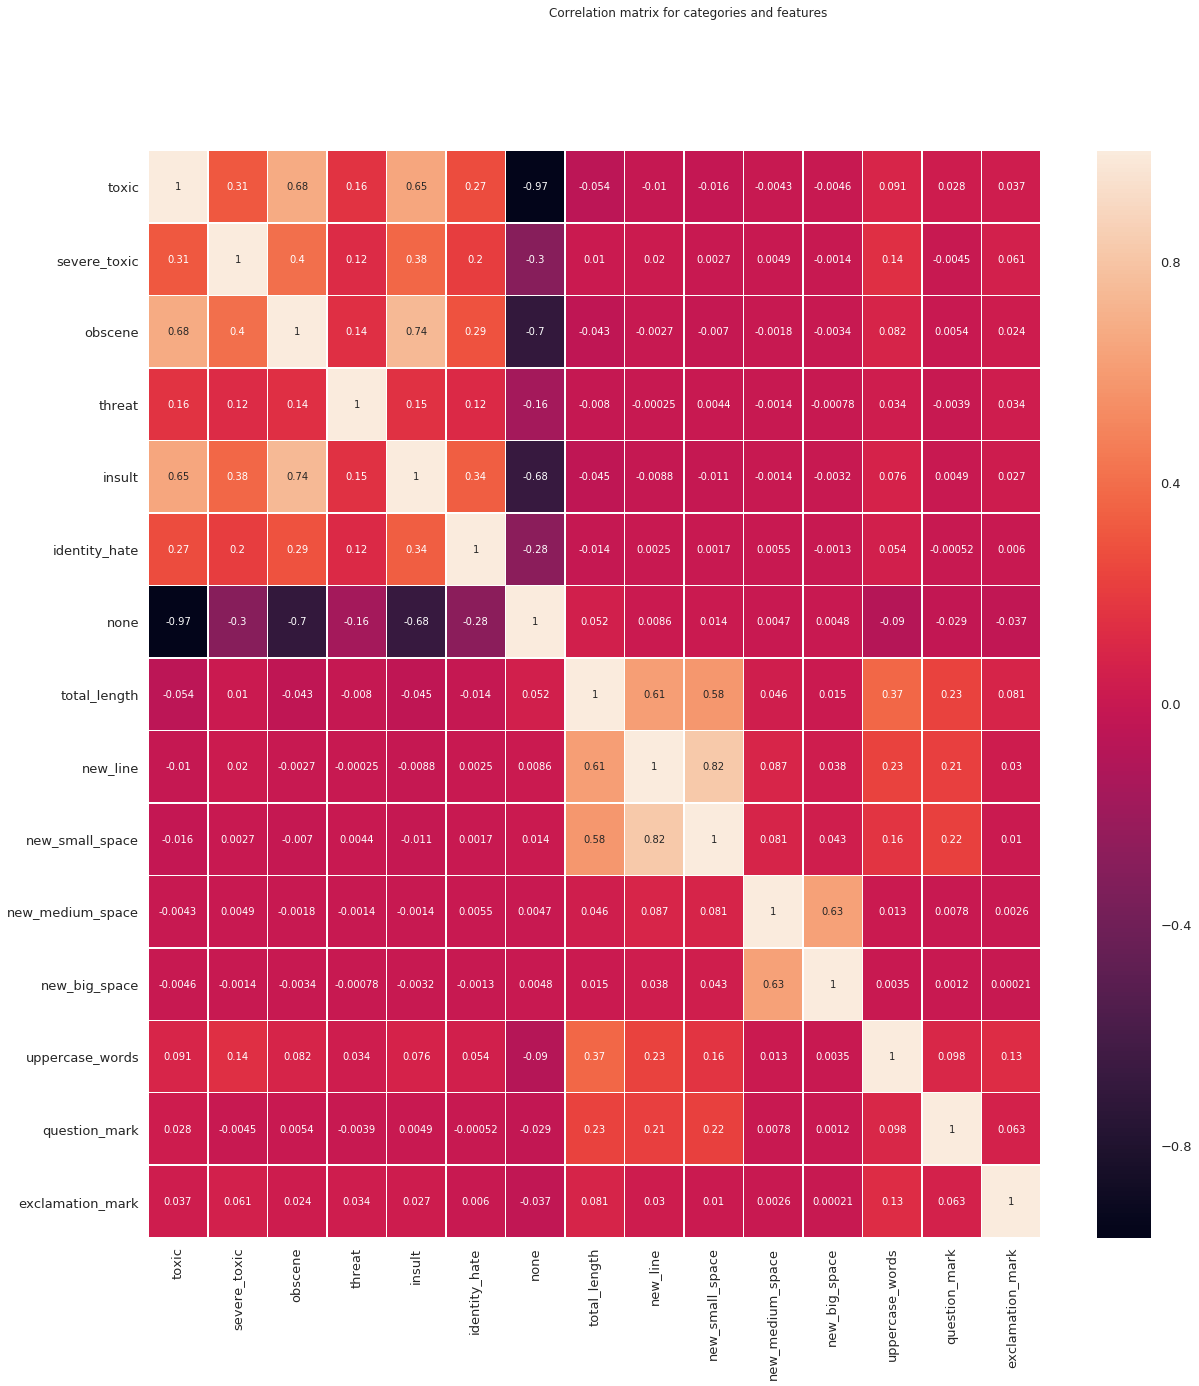

In [10]:
f, ax = plt.subplots(figsize=(20, 20))
f.suptitle('Correlation matrix for categories and features')
sns.heatmap(df_train[COLUMNS].corr(), annot=True, linewidths=.5, ax=ax)

Note: small, medium and big space features are inclusive, meaning that all 'big_space' are medium and small 
    ones (same for medium_space)

    The new correlation matrix with the added features does not show any strong correlations.
    One thing worth noting is that 'uppercase_words' (which could be assimilated to 'yelling') is slightly more 
    correlated.
    'uppercase_words' are correlated with 'exclamation_mark' up to 0.13 which could mean that people express the 
    urge to add as many '!' as possible when they are 'yelling' ;)

There is nothing else that comes in mind that I could explore. Please feel free to suggest any idea in comments below.

WORD ANALYSIS

In [11]:
word_counter = {}


def clean_text(text):
    text = re.sub('[{}]'.format(string.punctuation), ' ', text.lower())
    return ' '.join([word for word in text.split() if word not in (stop)])

for categ in CATEGORIES:
    d = Counter()
    df_train[df_train[categ] == 1]['comment_text'].apply(lambda t: d.update(clean_text(t).split()))
    word_counter[categ] = pd.DataFrame.from_dict(d, orient='index')\
                                        .rename(columns={0: 'count'})\
                                        .sort_values('count', ascending=False)

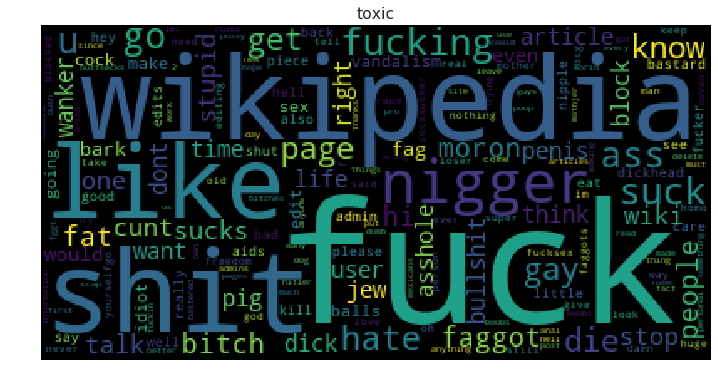

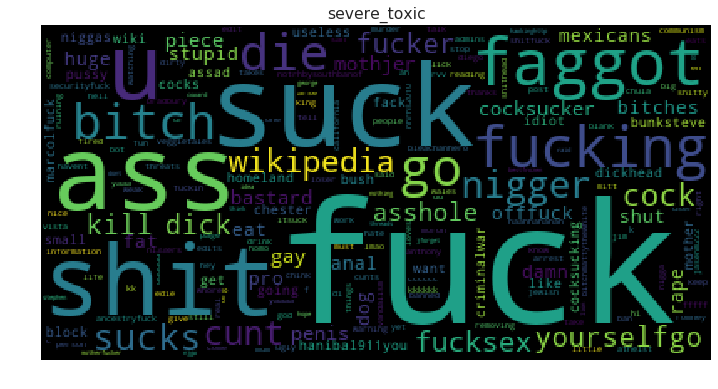

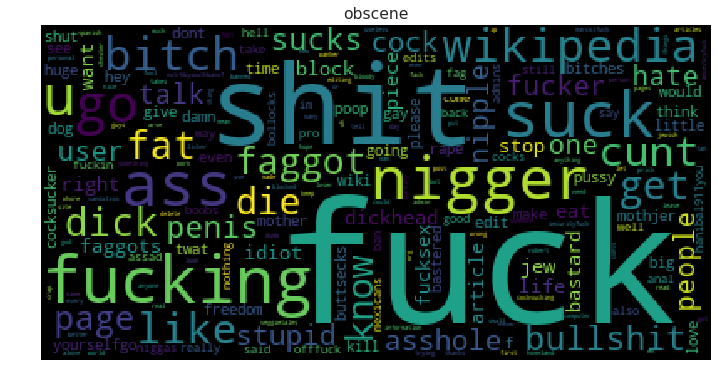

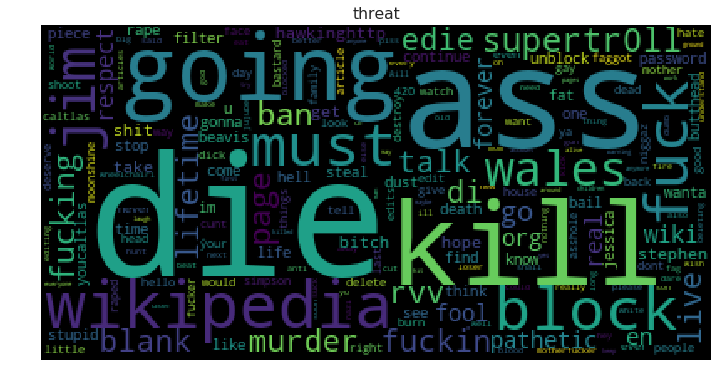

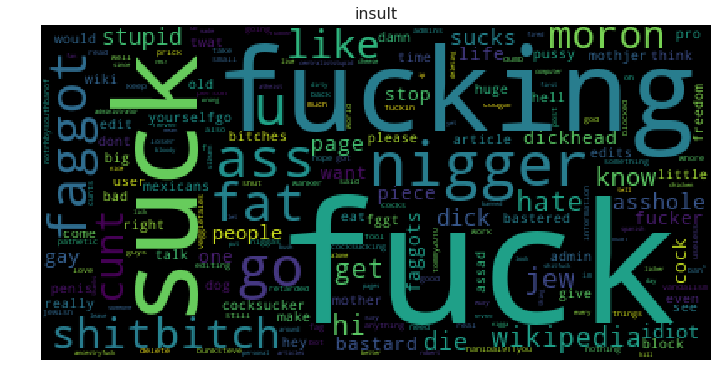

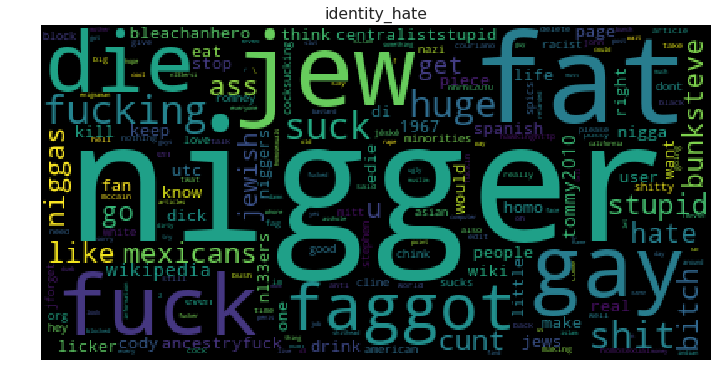

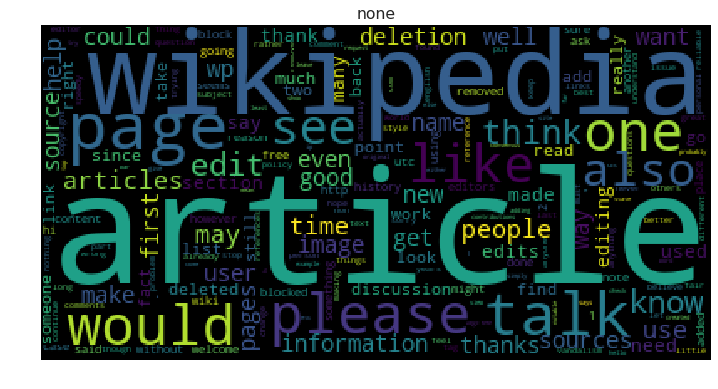

In [12]:
for w in word_counter:
    wc = word_counter[w]

    wordcloud = WordCloud(
          background_color='black',
          max_words=200,
          max_font_size=100, 
          random_state=4561
         ).generate_from_frequencies(wc.to_dict()['count'])

    fig = plt.figure(figsize=(12, 8))
    plt.title(w)
    plt.imshow(wordcloud)
    plt.axis('off')

    plt.show()

CONCLUSION

In this, we've found out that the categories we need to predict are overlapping each over. In the basic exploration of words contained in the comments, we can say that the vocabulary is quite similar across all categories except for the 'none' one. While this might be enough to detect unwanted comments, it is clearly not enough to categorised them.